# Importing the right libraries


In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from neural_networks.rbf_layer import RBFLayer, InitCentersRandom

# Load the data (once)


## Reading the files


In [30]:
df = pd.read_excel(
    "../data/Data_apple_ibm.xlsx", sheet_name="APPLE_1min", names=["date", "prices"]
)
df["returns"] = df["prices"].pct_change().fillna(0)
df["variance"] = df["returns"].rolling(100).var()
df["vol"] = (
    df["returns"].rolling(100).std().apply(lambda x: x * np.sqrt(252 * 60 * 6.5))
)
df["volvol"] = df["vol"].rolling(100).std()
df = df.dropna().reset_index(drop=True)
df.head()

,date,prices,returns,variance,vol,volvol
0,2024-01-02 13:45:00,188.90,0.000000,2.187464e-07,0.146623,0.022202
1,2024-01-02 13:46:00,188.90,0.000000,2.155420e-07,0.145545,0.022090
2,2024-01-02 13:47:00,188.90,0.000000,2.155420e-07,0.145545,0.021974
3,2024-01-02 13:48:00,188.88,-0.000106,2.155696e-07,0.145555,0.021851
4,2024-01-02 13:49:00,188.85,-0.000159,2.129898e-07,0.144681,0.021715


## Adding the feature to predict the next couple of hour

The next couple of hour trend is refered as the target variable. The target variable the coefficient from the forward looking linear regression.


In [31]:
df["target"] = np.nan

FORWARD_WINDOW = 60 * 1  # 6 hours

for index, row in tqdm(
    df.iloc[:-FORWARD_WINDOW].iterrows(),
    total=len(df) - FORWARD_WINDOW,
    desc="Calculating targets",
):
    x = np.array([i for i in range(0, FORWARD_WINDOW)]).reshape(-1, 1)  # fake x values
    y = (
        df["prices"].iloc[index : index + FORWARD_WINDOW].to_numpy().reshape(-1, 1)
    )  # y values
    beta = np.linalg.inv(x.T @ x) @ x.T @ y
    df.loc[index, "target"] = beta[0][0]


df = df.dropna().reset_index(drop=True)
df.head()

Calculating targets: 100%|██████████| 13211/13211 [00:03<00:00, 4257.52it/s]


,date,prices,returns,variance,vol,volvol,target
0,2024-01-02 13:45:00,188.90,0.000000,2.187464e-07,0.146623,0.022202,4.744568
1,2024-01-02 13:46:00,188.90,0.000000,2.155420e-07,0.145545,0.022090,4.744633
2,2024-01-02 13:47:00,188.90,0.000000,2.155420e-07,0.145545,0.021974,4.744604
3,2024-01-02 13:48:00,188.88,-0.000106,2.155696e-07,0.145555,0.021851,4.744601
4,2024-01-02 13:49:00,188.85,-0.000159,2.129898e-07,0.144681,0.021715,4.744522


Text(0.5, 1.0, 'Stock Price and Target')

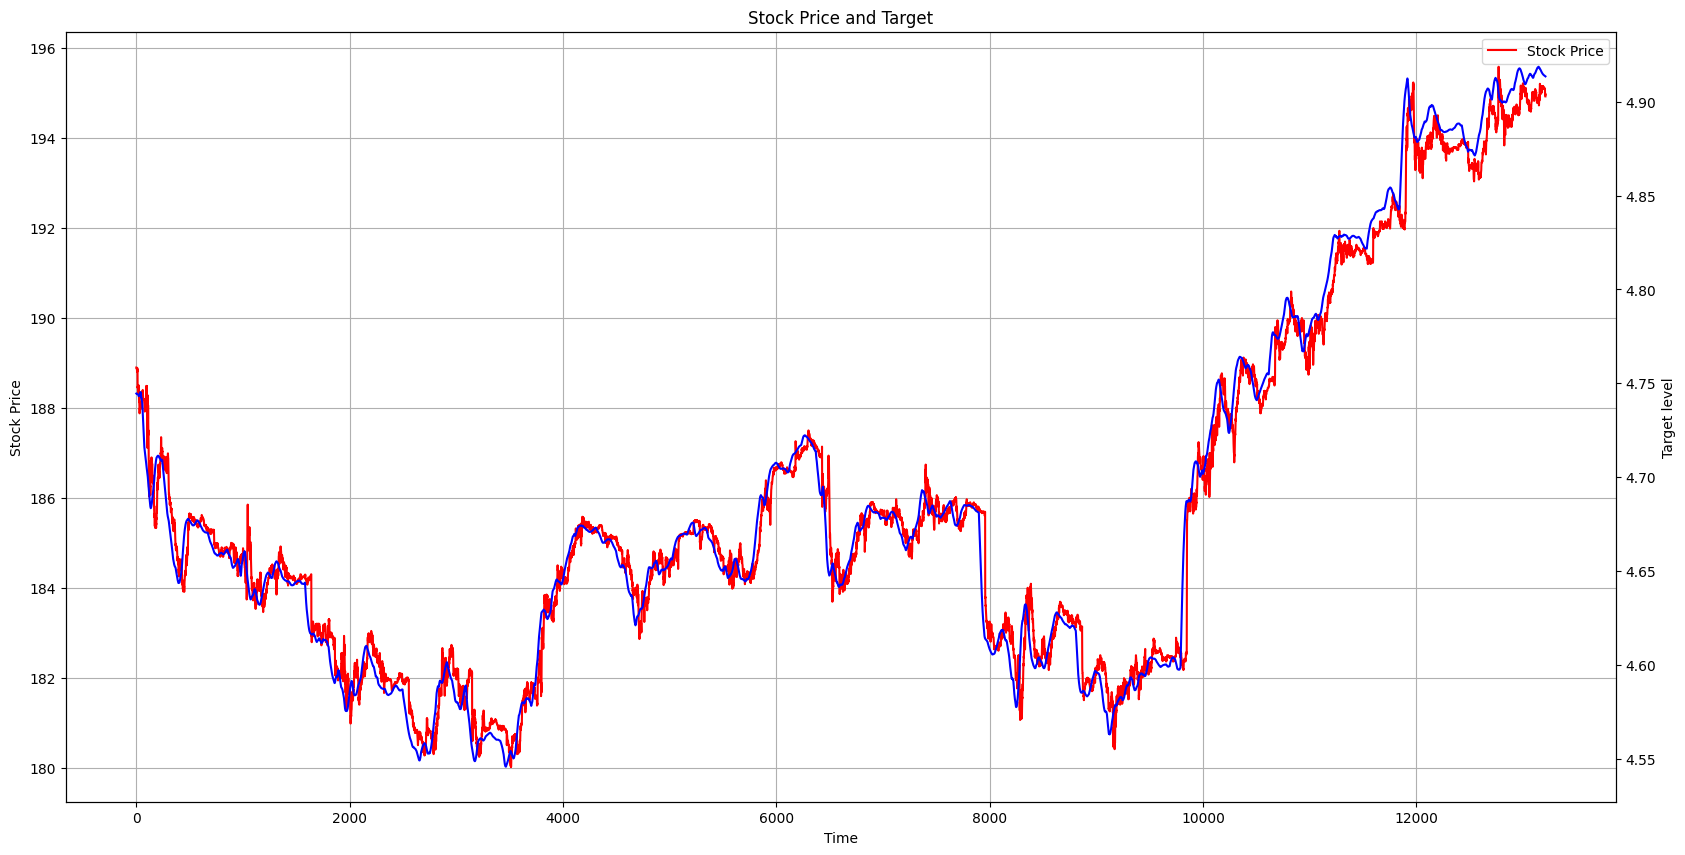

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.prices, color="red", label="Stock Price")
axl = ax.twinx()
axl.plot(df.target, color="blue", label="Target")
axl.set_ylabel("Target level")
ax.set_xlabel("Time")
ax.set_ylabel("Stock Price")
ax.legend()
ax.grid()
ax.set_title("Stock Price and Target")

## Creating train and test data sets


In [33]:
# TODO: Kalman is coming here

X = df[["prices", "vol", "volvol", "returns"]].to_numpy()
Y = df["target"].to_numpy().reshape(-1, 1)

TEST_PERCENT = 0.15
TRAIN_PERCENT = 1 - TEST_PERCENT

X_train = X[: int(X.shape[0] * TRAIN_PERCENT)]
X_test = X[int(X.shape[0] * TRAIN_PERCENT) :]
Y_train = Y[: int(Y.shape[0] * TRAIN_PERCENT)]
Y_test = Y[int(Y.shape[0] * TRAIN_PERCENT) :]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((11229, 4), (1982, 4), (11229, 1), (1982, 1))

## Scaling/normilizing the data


In [34]:
X_train_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train)
X_test_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

Y_train_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_train_scaled = Y_train_scaler.fit_transform(Y_train)
Y_test_scaler = MinMaxScaler()  # MinMaxScaler() # RobustScaler() # StandardScaler()
Y_test_scaled = Y_test_scaler.fit_transform(Y_test)

# Neural networks

### Defining the model


In [47]:
# Build the model
model = tf.keras.models.Sequential()
model.add(
    RBFLayer(
        output_dim=16,
        initializer=InitCentersRandom(X_train_scaled),
        betas=1.0,
        input_shape=(X_train_scaled.shape[-1],),
    )
)
model.add(tf.keras.layers.Reshape((1, 16)))
model.add(tf.keras.layers.LSTM(units=8, activation="relu", dropout=0.1))
model.add(tf.keras.layers.Dense(1))


# Compile the model
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)

### Training the model

In [48]:
# Train the model
history = model.fit(
    X_train,
    Y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.2,
    shuffle=False,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=5,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)
model.save('../models/rbf_lstm.h5')

Epoch 1/100
141/141 [==============================] - 3s 6ms/step - loss: 20.8929 - mean_squared_error: 20.8929 - val_loss: 20.7541 - val_mean_squared_error: 20.7541
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 19.6394 - mean_squared_error: 19.6394 - val_loss: 19.5146 - val_mean_squared_error: 19.5146
Epoch 3/100
141/141 [==============================] - 1s 5ms/step - loss: 18.4427 - mean_squared_error: 18.4427 - val_loss: 18.3306 - val_mean_squared_error: 18.3306
Epoch 4/100
141/141 [==============================] - 1s 6ms/step - loss: 17.3001 - mean_squared_error: 17.3001 - val_loss: 17.1999 - val_mean_squared_error: 17.1999
Epoch 5/100
141/141 [==============================] - 1s 7ms/step - loss: 16.2097 - mean_squared_error: 16.2097 - val_loss: 16.1206 - val_mean_squared_error: 16.1206
Epoch 6/100
141/141 [==============================] - 1s 4ms/step - loss: 15.1695 - mean_squared_error: 15.1695 - val_loss: 15.0907 - val_mean_squared_error: 15.090

#### Comparing loss and validation loss

Text(0.5, 1.0, 'Training and Validation loss')

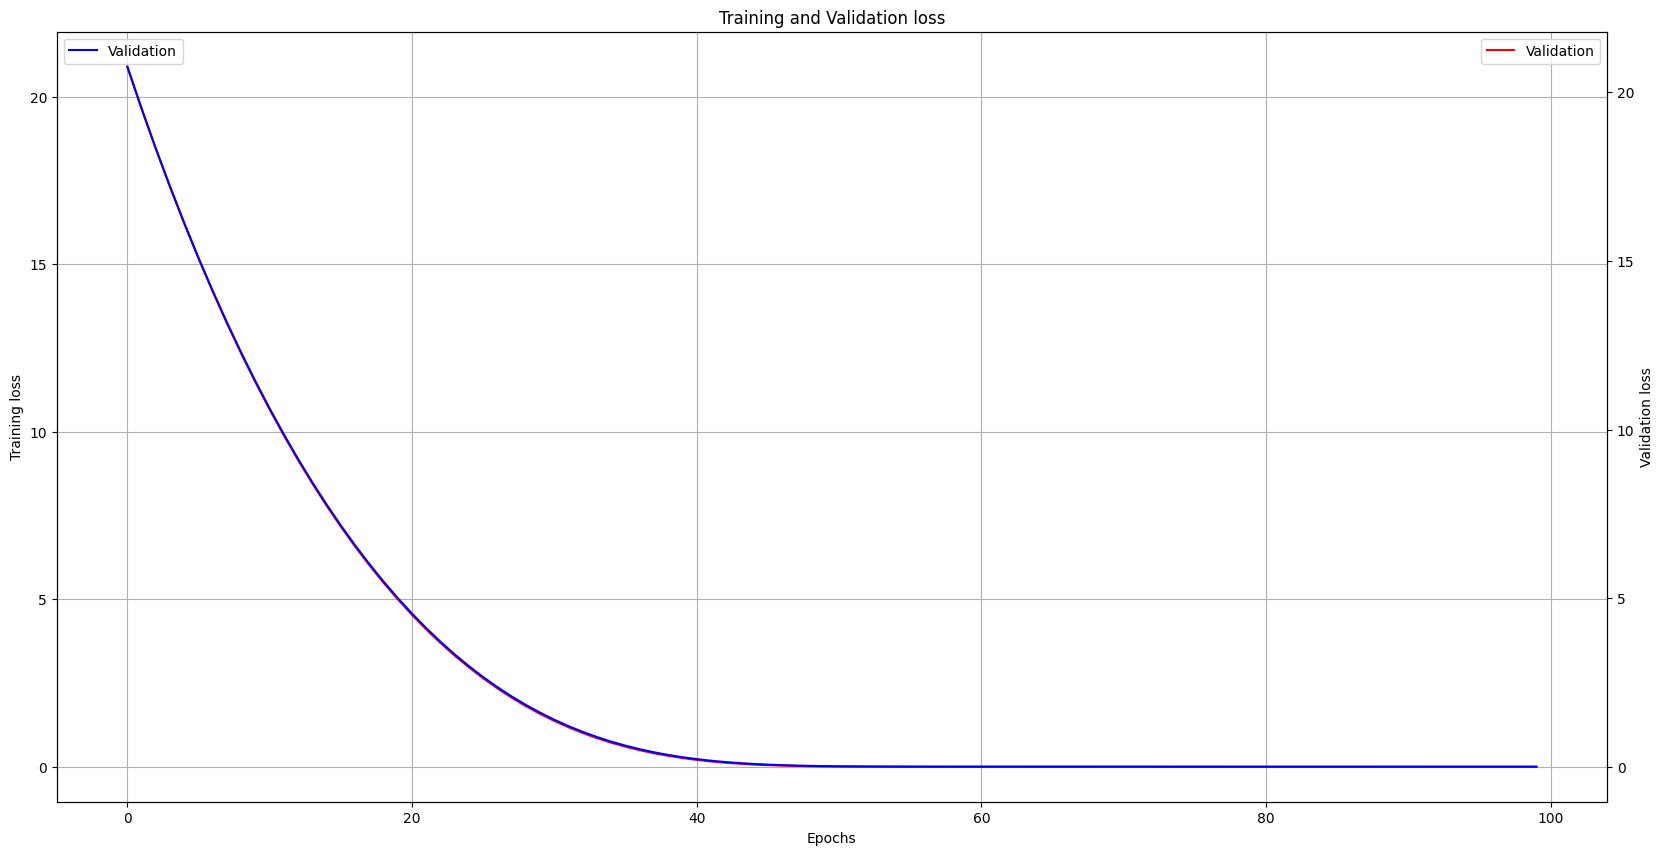

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(history.history['loss'], color='red',label='Validation')
axl=ax.twinx()
axl.plot(history.history['val_loss'], color='blue',label='Validation')
axl.set_ylabel("Validation loss")
axl.legend(loc='upper left')
ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss")
ax.legend()
ax.grid()
ax.set_title("Training and Validation loss")

# Explore the predictions

In [50]:
Y_test_predicted_scaled = model.predict(X_test_scaled)
Y_test_predicted = Y_test_scaler.inverse_transform(Y_test_predicted_scaled)
Y_test_true = Y_test_scaler.inverse_transform(Y_test_scaled)

Y_train_predicted_scaled = model.predict(X_train_scaled)
Y_train_predicted = Y_train_scaler.inverse_transform(Y_train_predicted_scaled)
Y_train_true = Y_train_scaler.inverse_transform(Y_train_scaled)

351/351 [==============================] - 1s 3ms/step


62/62 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'On training set')

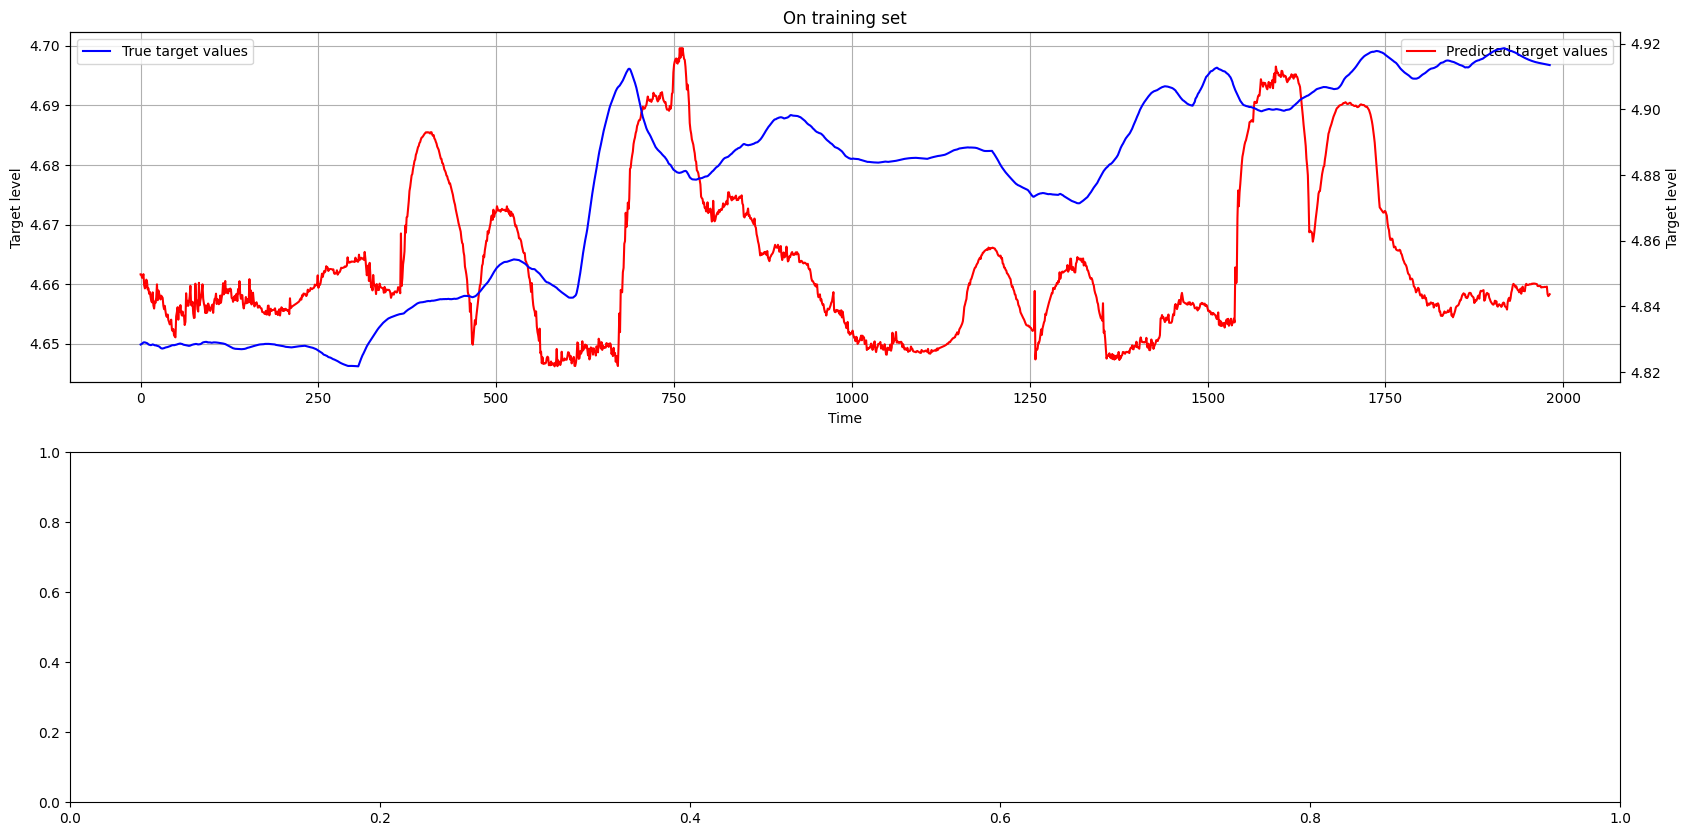

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(model.predict(X_test_scaled), color='red',label='Predicted target values')
axl=ax[0].twinx()
axl.plot(Y_test, color='blue',label='True target values')
axl.set_ylabel("Target level")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Target level")
ax[0].legend()
axl.legend(loc='upper left')
ax[0].grid()
ax[0].set_title("On training set")

# ax[1].plot(Y_test_predicted, color='red',label='Predicted target values')
# axl=ax[1].twinx()
# axl.plot(Y_test_true, color='blue',label='True target values')
# axl.set_ylabel("Target level")
# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Target level")
# ax[1].legend()
# axl.legend(loc='upper left')
# ax[1].grid()
# ax[1].set_title("On test set")